# Parse data from Woods & Poole County Forecast Files

In [194]:
import warnings
import pandas as pd
import glob
import os

USER = 'aolsen'

pd.options.display.float_format = '{:,.0f}'.format
warnings.filterwarnings('ignore')

In [195]:
bayareafips_full = {'06001': 'Alameda',
                    '06013': 'Contra Costa',
                    '06041': 'Marin',
                    '06055': 'Napa',
                    '06075': 'San Francisco',
                    '06081': 'San Mateo',
                    '06085': 'Santa Clara',
                    '06097': 'Sonoma',
                    '06095': 'Solano'}

In [196]:
cog_regions = {'06001': 'ABAG/MTC',
               '06013': 'ABAG/MTC',
               '06041': 'ABAG/MTC',
               # '06053': 'AMBAG',
               '06055': 'ABAG/MTC',
               # '06069': 'AMBAG',
               '06075': 'ABAG/MTC',
               '06073': 'SANDAG',
               '06081': 'ABAG/MTC',
               '06085': 'ABAG/MTC',
               # '06087': 'AMBAG',
               '06095': 'ABAG/MTC',
               '06097': 'ABAG/MTC',
               # '06077': 'SJCOG',
               # '06099': 'STANCOG',
               # '06047': 'MCAG',
               '06025': 'SCAG',  # imperial
               '06037': 'SCAG',   # LA
               '06071': 'SCAG',  # san bernadino
               '06059': 'SCAG',  # orange
               '06065': 'SCAG',  # riverside
               '06111': 'SCAG',  # ventura
               '06067': 'SACOG',  # 'yolo'
               '06101': 'SACOG',  # 'sutter'
               '06113': 'SACOG',  # 'yolo'
               '06115': 'SACOG'
               }

cog_regions

{'06001': 'ABAG/MTC',
 '06013': 'ABAG/MTC',
 '06041': 'ABAG/MTC',
 '06055': 'ABAG/MTC',
 '06075': 'ABAG/MTC',
 '06073': 'SANDAG',
 '06081': 'ABAG/MTC',
 '06085': 'ABAG/MTC',
 '06095': 'ABAG/MTC',
 '06097': 'ABAG/MTC',
 '06025': 'SCAG',
 '06037': 'SCAG',
 '06071': 'SCAG',
 '06059': 'SCAG',
 '06065': 'SCAG',
 '06111': 'SCAG',
 '06067': 'SACOG',
 '06101': 'SACOG',
 '06113': 'SACOG',
 '06115': 'SACOG'}

In [197]:
emp_name_to_naics_2 = {
    'FINANCE and INSURANCE EMPLOYMENT': '52',
    'INFORMATION EMPLOYMENT': '51',
    'RETAIL TRADE EMPLOYMENT': '44-45',
    'FEDERAL MILITARY EMPLOYMENT': '92',
    'STATE and LOCAL GOVERNMENT EMPLOYMENT': '92',
    'TRANSPORTATION and WAREHOUSING EMPLOYMENT': '48-49',
    'PROFESSIONAL and TECHNICAL SERVICES EMPLOYMENT': '54',
    'ACCOMMODATION and FOOD SERVICES EMPLOYMENT': '72',
    'ARTS, ENTERTAINMENT, and RECREATION EMPLOYMENT': '71',
    'REAL ESTATE and RENTAL and LEASE EMPLOYMENT': '53',
    'OTHER SERVICES, EXCEPT PUBLIC ADMINISTRATION EMPLOYMENT': '81',
    'MANAGEMENT of COMPANIES and ENTERPRISES EMPLOYMENT': '55',
    'ADMINISTRATIVE and WASTE SERVICES EMPLOYMENT': '56',
    'FEDERAL CIVILIAN GOVERNMENT EMPLOYMENT': '92',
    'FORESTRY, FISHING, RELATED ACTIVITIES and OTHER EMPLOYMENT': '11',
    'MINING EMPLOYMENT': '11',
    'CONSTRUCTION EMPLOYMENT': '23',
    'UTILITIES EMPLOYMENT': '22',
    # 'TOTAL EMPLOYMENT':'11',
    'FARM EMPLOYMENT': '11',
    'MANUFACTURING EMPLOYMENT': '31-33',
    'WHOLESALE TRADE EMPLOYMENT': '42',
    'HEALTH CARE and SOCIAL ASSISTANCE EMPLOYMENT': '62',
    'EDUCATIONAL SERVICES EMPLOYMENT': '61'
}

In [215]:
naics_to_abag = pd.read_excel(f'/Users/{USER}/Box/Modeling and Surveys/Regional Modeling/Regional Forecast PBA50/mappings/NAICS_to_ABAG_SECTORS.xlsx',engine='openpyxl',sheet_name='both')
naics_to_vs = naics_to_abag.set_index('NAICS-2').CES_VS
naics_to_abag6 = naics_to_abag.set_index('NAICS-2').MTCname.str.upper()
naics_to_abag11 = naics_to_abag.set_index('NAICS-2')['ABAG-11']
naics_to_abag6.index
naics_to_abag

,NAICS-2,ABAG-6,ABAG-11,MTCname,eddname,acs,ind_census,CES_VS
0,11,Agriculture & Natural Resources,Agriculture & Natural Resources,agrempn,Agriculture and Natural Resources,"Agriculture, forestry, fishing and hunting, an...",ind_other,Farm
1,21,Agriculture & Natural Resources,Agriculture & Natural Resources,agrempn,Agriculture and Natural Resources,"Agriculture, forestry, fishing and hunting, an...",ind_other,"Mining, Logging & Construction"
2,22,"Manufacturing, Wholesale & Transportation",Transportation & Utilities,mwtempn,"Manufacturing, Wholesale, Transportation and U...","Transportation and warehousing, and utilities",ind_other,"Trade, Transportation & Utilities"
3,23,Other,Construction,othempn,Construction,Construction,ind_other,"Mining, Logging and Construction"
4,31,"Manufacturing, Wholesale & Transportation",Manufacturing & Wholesale,mwtempn,"Manufacturing, Wholesale, Transportation and U...",Manufacturing,ind_other,Manufacturing
5,32,"Manufacturing, Wholesale & Transportation",Manufacturing & Wholesale,mwtempn,"Manufacturing, Wholesale, Transportation and U...",Manufacturing,ind_other,Manufacturing
6,33,"Manufacturing, Wholesale & Transportation",Manufacturing & Wholesale,mwtempn,"Manufacturing, Wholesale, Transportation and U...",Manufacturing,ind_other,Manufacturing
7,42,"Manufacturing, Wholesale & Transportation",Manufacturing & Wholesale,mwtempn,"Manufacturing, Wholesale, Transportation and U...",Wholesale trade,ind_other,"Trade, Transportation & Utilities"
8,44,Retail,Retail,retempn,Retail,Retail trade,ind_retail,"Trade, Transportation & Utilities"
9,45,Retail,Retail,retempn,Retail,Retail trade,ind_retail,"Trade, Transportation & Utilities"


# Labor Force, Employment file

In [40]:
# labor force, employment detail data file

data_emp_fieldmap = pd.read_fwf('/Users/aolsen/Dropbox/My Mac (AOLSEN-MBP.local)/Documents/WP_Download_2023/SP_2023_CA/WPCOMP/CACOMP.CSV',
                                skiprows=121, skipfooter=24, widths=[2, 15, 92, 1], names=['no', 'variable', 'desc', 'no1'])

data_emp_fieldmap.variable = data_emp_fieldmap.variable.str.strip()
data_emp_fieldmap.desc = data_emp_fieldmap.desc.str.strip()
data_emp_fieldmap = data_emp_fieldmap.set_index('variable').desc

In [69]:
# read data file itself
data_emp = pd.read_csv('/Users/aolsen/Dropbox/My Mac (AOLSEN-MBP.local)/Documents/WP_Download_2023/SP_2023_CA/WPCOMP/CACOMP.CSV',
                       skiprows=3, skipfooter=75, dtype={'COUNTY': str})


In [42]:
# list of file row identifiers - we don't need most of these
IDENTIFIERS = ['COUNTY', 'TYPE', 'REGION',
               'EA', 'MSA', 'CSA', 'MDIV', 'MICRO', 'NAME']

In [180]:
# subset to bay area counties
data_emp_bayarea = data_emp[data_emp.COUNTY.isin(bayareafips_full)]

# drop not relevant identifiers - set the remaining variable to be the index variable. Rest of columns are years
data_emp_bayarea = data_emp_bayarea.drop(
    IDENTIFIERS[:-1], axis=1).set_index('NAME')

# turn to long format
data_emp_bayarea_l = data_emp_bayarea.stack().reset_index(name='value')


# some variables contain both a concept and a detail ('TOTL, 1-49 EST', 'TOTL, ALL EST')
# strip out just the year. The dictionary is just focused on the first component, which we call "stub"
data_emp_bayarea_l['variable_no_year'] = data_emp_bayarea_l.level_1.str.replace(
    ', \d{4}', '')


data_emp_bayarea_l['variable_stub'] = data_emp_bayarea_l['variable_no_year'].str.split(
    ',').apply(lambda x: x[0])

# column headers encode both concept and years. Extract.
data_emp_bayarea_l['variable'] = data_emp_bayarea_l.level_1.str.slice(
    0, -6).str.strip()
data_emp_bayarea_l['year'] = data_emp_bayarea_l.level_1.str.slice(
    -4).astype(int)

# add descriptive field name from field map
data_emp_bayarea_l['variable_name'] = data_emp_bayarea_l.variable_stub.map(
    data_emp_fieldmap)


# drop unused var
data_emp_bayarea_l = data_emp_bayarea_l.drop(['level_1'], axis=1)


In [44]:
data_emp_bayarea_l[data_emp_bayarea_l.variable_stub == 'TOTL'].sample(3)

,NAME,value,variable_no_year,variable_stub,variable,year,variable_name
831,"SAN FRANCISCO, CA","34,863","TOTL, ALL EST",TOTL,"TOTL, ALL EST",2019,Total Number of Business Establishments
1034,"SAN MATEO, CA","20,224","TOTL, 1-49 EST",TOTL,"TOTL, 1-49 EST",2019,Total Number of Business Establishments
1195,"SANTA CLARA, CA","49,035","TOTL, ALL EST",TOTL,"TOTL, ALL EST",2019,Total Number of Business Establishments


# General Files

These are stored as a separate file for each variable (122 in total).

There is a mapping detailing what each file contains - we load the mapping and the data, and stitch together as appropriate.

In [45]:
VARIABLE_MAP_PATH = '/Users/aolsen/Dropbox/My Mac (AOLSEN-MBP.local)/Documents/WP_Download_2023/SP_2023_CA/CAFILENM.TXT'
VARIABLE_PATH = '/Users/aolsen/Dropbox/My Mac (AOLSEN-MBP.local)/Documents/WP_Download_2023/SP_2023_CA/WPVAR'
DATA_PATH = '/Users/aolsen/Dropbox/My Mac (AOLSEN-MBP.local)/Documents/WP_Download_2023/SP_2023_CA/WPVAR'

In [74]:
# load the file name to variable map into a series

variable_file_map = pd.read_fwf(
    VARIABLE_MAP_PATH, skiprows=10, skipfooter=119, widths=[13, 76])
variable_file_map = variable_file_map.set_index('FILE NAME').VARIABLE
variable_file_map

FILE NAME
CA001.CSV                                     TOTAL POPULATION
CA002.CSV                         POPULATION AGE UNDER 5 YEARS
CA003.CSV                          POPULATION AGE 5 to 9 YEARS
CA004.CSV                        POPULATION AGE 10 to 14 YEARS
CA005.CSV                        POPULATION AGE 15 to 19 YEARS
                                   ...                        
CA118.CSV    SPORTING GOODS, HOBBY, BOOK, and MUSIC STORES ...
CA119.CSV              GENERAL MERCHANDISE STORES RETAIL SALES
CA120.CSV                     MISCELLANEOUS STORE RETAIL SALES
CA121.CSV                      NONSTORE RETAILERS RETAIL SALES
CA122.CSV                     EATING and DRINKING PLACES SALES
Name: VARIABLE, Length: 122, dtype: object

In [47]:
for fname in glob.glob1(VARIABLE_PATH, '*CSV'):

    # construct the path
    full_fname = os.path.join(VARIABLE_PATH, fname)

    # read the datafile
    this_df = pd.read_csv(full_fname, skiprows=3,
                          skipfooter=87, dtype={'COUNTY': str})

In [148]:
def fetch_and_stitch_data(VARIABLE_PATH, variable_file_map, subset=False):
    """
    Fetches Woods and Poole County forecast data, stitches the data together from different files,
    and stores it in a long format dataframe.

    Args:
        VARIABLE_PATH (str): Path to the directory containing variable files.
        variable_file_map (dict): A dictionary mapping file names to variable names.
        bayareafips_full (list): List of county FIPS codes for the Bay Area.

    Returns:
        pandas.DataFrame: The stitched and processed data in a long format dataframe.
    """

    storage = {}

    # loop over list of all variable files in folder
    for fname in glob.glob1(VARIABLE_PATH, '*CSV'):

        # construct the path
        full_fname = os.path.join(VARIABLE_PATH, fname)

        # read the datafile - ensure COUNTY fips code doesn't lose leading 0
        this_df = pd.read_csv(full_fname, skiprows=3,
                              skipfooter=87, dtype={'COUNTY': str})

        # look up from the file name what variable it represents
        this_var = variable_file_map[fname]

        # store in a dict keyed on the variable name
        storage[this_var] = this_df

    # combine the individual variables
    wp_data = pd.concat(storage, names=['VARIABLE', 'ROWID']).reset_index()

    # assign COG region based on county
    wp_data['cog_region'] = wp_data.COUNTY.map(cog_regions)
    #dof['cog_region'] = dof.STCOUNTY.map(cog_regions)
    wp_data['cog_region'] = wp_data['cog_region'].fillna('Other COG')

    # drop non-cog counties
    wp_data = wp_data[wp_data.cog_region.notna()]

    # subset to bay area counties
    if subset:
        wp_data = wp_data[wp_data.COUNTY.isin(bayareafips_full)]

    wp_data = wp_data.drop(wp_data.columns[1:11], axis=1)
    wp_data_l = wp_data.set_index(
        ['VARIABLE', 'NAME', 'cog_region']).stack().reset_index(name='value')


    wp_data_l = wp_data_l.rename(
        columns={'VARIABLE': 'variable', 'NAME': 'county', 'level_3': 'year'})
    wp_data_l['county'] = wp_data_l['county'].str.replace(', CA','').str.title()
    

    wp_data_l.year = wp_data_l.year.astype(int)

    return wp_data_l

wp_data_l = fetch_and_stitch_data(
    VARIABLE_PATH, variable_file_map, subset=False)
wp_data_l.sample(3)

,variable,county,cog_region,year,value
222028,SUPPLEMENTS to WAGES and SALARIES,Yolo,SACOG,2001,"1,118"
529443,TOTAL EMPLOYMENT,San Francisco,ABAG/MTC,2044,"1,392"
78476,MEAN HOUSEHOLD TOTAL PERSONAL INCOME (in 2012...,Los Angeles-Long Beach-Anaheim,Other COG,1969,69946


## Summaries

### Population by age

In [221]:
years_5 = range(2010, 2051, 5)

age_drop_cats = ['0 to 17 years',
       '15 to 17 years','65 years and over','18 to 24 years']
wp_data_pop_age = wp_data_l[wp_data_l.variable.str.contains('POPULATION AGE ')]
wp_data_pop_age.variable = wp_data_pop_age.variable.str.replace('POPULATION AGE','').str.lower().str.strip()

# drop double counting categories
wp_data_pop_age = wp_data_pop_age.loc[~wp_data_pop_age.variable.isin(age_drop_cats)]

wp_data_pop_age.value = pd.to_numeric(wp_data_pop_age.value,errors='coerce')


wp_data_pop_age.loc[(wp_data_pop_age.cog_region=='ABAG/MTC')&(wp_data_pop_age.year==2022)].groupby(['county','year']).value.sum()
wp_data_pop_age = wp_data_pop_age.rename(columns={'variable':'age_bin'})

wp_data_pop_age_county = wp_data_pop_age.query('year>2009').groupby(['year','cog_region','county','age_bin'],observed=True).value.sum().mul(1000).reset_index()


### Jobs by sector

In [222]:
years_5 = range(2010, 2051, 5)

emp_drop_cats = ['TOTAL EMPLOYMENT',
                 ]
wp_data_emp_sector = wp_data_l[wp_data_l.variable.str.contains('EMPL')]
#wp_data_emp_sector.variable = wp_data_emp_sector.variable.str.replace('POPULATION AGE','').str.lower().str.strip()

# drop double counting categories
wp_data_emp_sector = wp_data_emp_sector.loc[~wp_data_emp_sector.variable.isin(
    emp_drop_cats)]

wp_data_emp_sector['naics_2'] = pd.to_numeric(wp_data_emp_sector.variable.map(
    emp_name_to_naics_2).str.slice(0,2))


wp_data_emp_sector.value = pd.to_numeric(
    wp_data_emp_sector.value, errors='coerce')
wp_data_emp_sector['sector_6'] = wp_data_emp_sector.naics_2.map(naics_to_abag6)


In [223]:
#wp_data_emp_sector.loc[(wp_data_emp_sector.cog_region=='ABAG/MTC')&(wp_data_emp_sector.year==2022)].groupby(['county','year']).value.sum()
wp_data_emp_sector = wp_data_emp_sector.rename(columns={'variable':'age_bin'})

wp_data_emp_sector_county = wp_data_emp_sector.query('year>2009').groupby(['year','cog_region','county','sector_6'],observed=True).value.sum().mul(1000).reset_index()
wp_data_emp_sector_county

,year,cog_region,county,sector_6,value
0,2010,ABAG/MTC,Alameda,AGREMPN,"2,654"
1,2010,ABAG/MTC,Alameda,FPSEMPN,"228,869"
2,2010,ABAG/MTC,Alameda,HEREMPN,"239,602"
3,2010,ABAG/MTC,Alameda,MWTEMPN,"137,177"
4,2010,ABAG/MTC,Alameda,OTHEMPN,"171,102"
...,...,...,...,...,...
31207,2060,SCAG,Ventura,FPSEMPN,"167,792"
31208,2060,SCAG,Ventura,HEREMPN,"270,998"
31209,2060,SCAG,Ventura,MWTEMPN,"77,363"
31210,2060,SCAG,Ventura,OTHEMPN,"87,412"


### Population

In [153]:

county_pop_totals = wp_data_l[wp_data_l.variable=='TOTAL POPULATION'].groupby(
    ['county', 'year']).value.sum().mul(1e3).astype(int)
county_pop_totals.unstack(0)

county,Alameda,Alpine,Amador,Anaheim-Santa Ana-Irvine,Bakersfield,Butte,Calaveras,California,Chico,Clearlake,...,Tulare,Tuolumne,Ukiah,United States,Vallejo,Ventura,Visalia,Yolo,Yuba,Yuba City
year,,,,,,,,,,,,,,,,,,,,,
1969,1060099,398,11240,1376796,325549,101057,13328,19711000,101057,18799,...,185701,21286,49733,201297999,168394,369811,185701,89817,44660,86435
1970,1073964,499,11969,1433709,331404,102750,13642,20044218,102750,19823,...,189460,22336,51278,203982313,173265,381900,189460,92482,44838,86983
1971,1084834,579,12549,1484913,336355,105915,13917,20348712,105915,20928,...,194127,23055,52001,206860314,178479,395599,194127,95306,45299,88358
1972,1100003,698,12734,1537769,336985,112742,14219,20585177,112742,21820,...,197626,23242,52488,209283987,181197,408227,197626,101633,44300,87492
1973,1089940,676,13512,1608582,343230,113168,14772,20867982,113168,23442,...,201779,24133,55014,211357665,183122,419017,201779,97635,44882,89953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056,1919141,1161,48978,3677242,1288874,241261,57222,47703815,241261,80200,...,617505,58021,94956,407663310,543364,975115,617505,295836,107457,232804
2057,1928942,1160,49221,3693551,1301881,242386,57570,48000425,242386,80584,...,622399,58127,95113,410337180,546580,979657,622399,298397,108227,234467
2058,1939044,1160,49464,3710313,1315019,243545,57920,48304249,243545,80968,...,627416,58233,95270,413081903,549885,984220,627416,301016,109002,236140


### Bay Area Total

In [154]:
# which vars to keep?
var_keep = ['TOTAL NUMBER of HOUSEHOLDS',
            'TOTAL POPULATION', 'TOTAL EMPLOYMENT']

In [155]:
bay_area_totals = wp_data_l[wp_data_l.variable.isin(var_keep)].groupby(
    ['variable', 'year']).value.sum().unstack(0).mul(1e3).astype(int)
bay_area_totals

variable,TOTAL EMPLOYMENT,TOTAL NUMBER of HOUSEHOLDS,TOTAL POPULATION
year,,,
1969,143564693,100017242,315083727
1970,143874004,102361247,319707818
1971,143980427,104979382,324291600
1972,148612602,107983181,327946761
1973,155489715,110944453,331516469
...,...,...,...
2056,515241343,257542787,680307104
2057,519990193,259200806,684692983
2058,524769095,260864070,689192363


### County Totals

In [156]:
county_totals = wp_data_l[wp_data_l.variable.isin(var_keep)].groupby(
    ['county', 'variable', 'year']).value.sum().unstack(0).mul(1e3).astype(int)

In [157]:
county_households = wp_data_l.query("variable=='TOTAL NUMBER of HOUSEHOLDS'").groupby([
    'county', 'year']).value.sum().unstack(0)

In [158]:
# Household growth, 2020 - 2050
#county_households.loc['2050'] - county_households.loc['2020']

### COG Totals

<AxesSubplot: xlabel='year'>

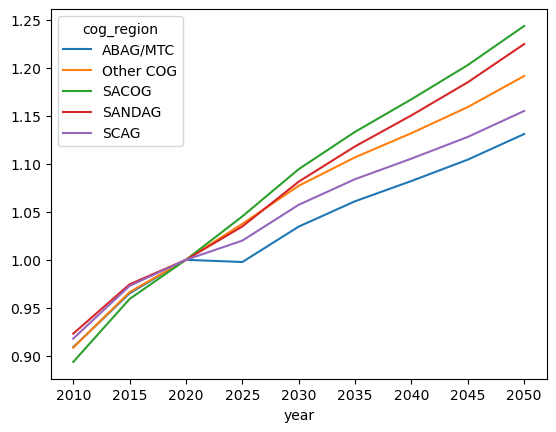

In [159]:
COG_households = wp_data_l.query("variable=='TOTAL NUMBER of HOUSEHOLDS'").groupby([
    'cog_region', 'year']).value.sum().unstack(0)
# county_households.plot()
COG_households = COG_households.mul(1000).astype(int)

(COG_households.loc[years_5]/COG_households.loc[2020]).plot()

<AxesSubplot: xlabel='cog_region'>

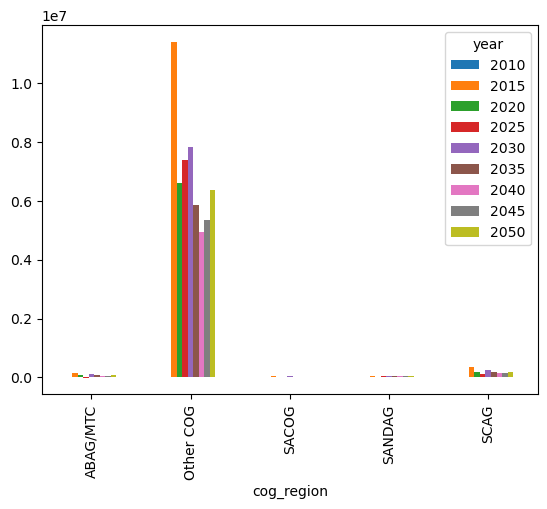

In [160]:
COG_households.loc[years_5].diff().T.plot(kind='bar')

In [224]:
wb = pd.ExcelWriter('/Users/aolsen/Box/Modeling and Surveys/Projects/Regional Growth Forecast Update/Forecasts/harvested/woods_poole_summary.xlsx')


In [226]:
wp_data_emp_sector.to_excel(wb,'wp_data_emp_sector')

,age_bin,county,cog_region,year,value,naics_2,sector_6
28980,FINANCE and INSURANCE EMPLOYMENT,United States,Other COG,1969,"3,878",52,FPSEMPN
28981,FINANCE and INSURANCE EMPLOYMENT,United States,Other COG,1970,"4,006",52,FPSEMPN
28982,FINANCE and INSURANCE EMPLOYMENT,United States,Other COG,1971,"4,147",52,FPSEMPN
28983,FINANCE and INSURANCE EMPLOYMENT,United States,Other COG,1972,"4,332",52,FPSEMPN
28984,FINANCE and INSURANCE EMPLOYMENT,United States,Other COG,1973,"4,592",52,FPSEMPN
...,...,...,...,...,...,...,...
965995,EDUCATIONAL SERVICES EMPLOYMENT,Yuba,SACOG,2056,0,61,HEREMPN
965996,EDUCATIONAL SERVICES EMPLOYMENT,Yuba,SACOG,2057,0,61,HEREMPN
965997,EDUCATIONAL SERVICES EMPLOYMENT,Yuba,SACOG,2058,0,61,HEREMPN
965998,EDUCATIONAL SERVICES EMPLOYMENT,Yuba,SACOG,2059,0,61,HEREMPN


In [227]:

wp_data_pop_age_county.to_excel(wb,'wp_data_pop_age_county')

In [228]:
wb.close()